In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

In [2]:
random.seed = 20

## Load training dataset

In [3]:
# Root
from MyDataset import MyDataset

root = '../../train_val_test_dataset/IEEE_Case118/UC'

# Load all data with empty input
dataset = MyDataset(root=root, data_list=[])

# Get train dataset
train_size = 700

# Set batch size
batch_size = 10
# Length of indicidual prediction
unit_length = 118

# Get train dataset
train_dataset = dataset[:train_size]
# Create train loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Set hyper-parameters
input_dim = 32
hidden_dim = 24
output_dim = 12

# Set device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## ANN

In [4]:
from GNNClassifier import UCANN

# Initialize the model
model = UCANN(input_dim, hidden_dim, output_dim)
model.to(device)

UCANN(
  (ann): Sequential(
    (0): Linear(in_features=32, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=12, bias=True)
    (5): Sigmoid()
  )
)

#### ANN model training

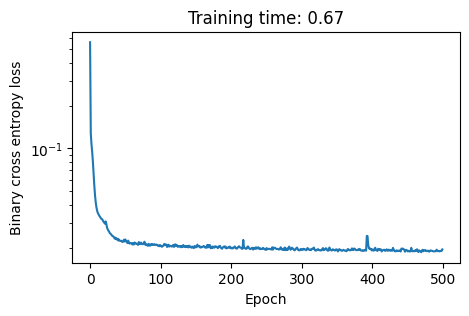

In [5]:
# Set number of epochs
epochs = 500

# Set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Set model to training mode
model.train()

# Model training and validation
epoch_loss = []
start_time = time.time()
for epoch in range(epochs):
    batch_loss = []
    for loader in train_loader:
        loader.to(device)

        optimizer.zero_grad()

        y_pred = model(loader.x, loader.edge_index)

        loss = F.binary_cross_entropy(y_pred, loader.y)

        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    epoch_loss.append(np.mean(batch_loss))

end_time = time.time()
training_time = (end_time - start_time)/60

plt.figure(figsize=(5, 3))
plt.plot(epoch_loss)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Binary cross entropy loss')
plt.title(f'Training time: {training_time:.2f}')
plt.show()
plt.close('all')

#### Save ANN model

In [6]:
torch.save(model, './trained_model/UCANN_model.pt')

#### ANN model testing

In [7]:
# Load the model
model = torch.load('./trained_model/UCANN_model.pt')

########################### Testing dataset ###########################
# Get test dataset
test_size = 200
test_dataset = dataset[-test_size:]

# Create test loader
############ Shuffle cannot beb True for testing ##################
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
with torch.no_grad():
    for i, loader in enumerate(test_loader):
        loader.to(device)
        # Get ground true
        ground_true = loader.y.cpu().detach().numpy()
        # Save ground true
        for j in range(batch_size):
            file_path = f'./model_evaluation/ANN/UC_true/true_{i*batch_size+j+1}.csv'
            pd.DataFrame(ground_true[j*unit_length:(j+1)*unit_length]).to_csv(file_path, columns=None, index=None, header=None)

        # Get prediction
        pred = model(loader.x, loader.edge_index)
        pred = (pred>0.5).float()
        pred = pred.cpu().detach().numpy()
        # Save prediction
        for j in range(batch_size):
            file_path = f'./model_evaluation/ANN/UC_pred/pred_{i*batch_size+j+1}.csv'
            pd.DataFrame(pred[j*unit_length:(j+1)*unit_length]).to_csv(file_path, columns=None, index=None, header=None)



########################### Complete dataset ###########################
# Get test dataset
test_dataset = dataset[:]

# Create test loader
############ Shuffle cannot beb True for testing ##################
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
with torch.no_grad():
    for i, loader in enumerate(test_loader):
        loader.to(device)
        # Get ground true
        ground_true = loader.y.cpu().detach().numpy()
        # Save ground true
        for j in range(batch_size):
            file_path = f'./model_evaluation//ANN/UC_true_all/true_{i*batch_size+j+1}.csv'
            pd.DataFrame(ground_true[j*unit_length:(j+1)*unit_length]).to_csv(file_path, columns=None, index=None, header=None)

        # Get prediction
        pred = model(loader.x, loader.edge_index)
        pred = (pred>0.5).float()
        pred = pred.cpu().detach().numpy()
        # Save prediction
        for j in range(batch_size):
            file_path = f'./model_evaluation/ANN/UC_pred_all/pred_{i*batch_size+j+1}.csv'
            pd.DataFrame(pred[j*unit_length:(j+1)*unit_length]).to_csv(file_path, columns=None, index=None, header=None)

## SAGE

In [8]:
from GNNClassifier import UCSAGE

# Initialize the model
model = UCSAGE(input_dim, hidden_dim, output_dim)
model.to(device)

UCSAGE(
  (gnn): Sequential(
    (0): SAGEConv(32, 24, aggr=mean)
    (1): ReLU()
    (2): SAGEConv(24, 24, aggr=mean)
    (3): ReLU()
    (4): SAGEConv(24, 12, aggr=mean)
    (5): Sigmoid()
  )
)

#### SAGE model training

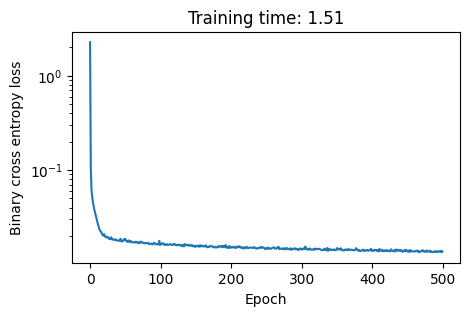

In [9]:
# Set number of epochs
epochs = 500

# Set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Set model to training mode
model.train()

# Model training and validation
epoch_loss = []
start_time = time.time()
for epoch in range(epochs):
    batch_loss = []
    for loader in train_loader:
        loader.to(device)

        optimizer.zero_grad()

        y_pred = model(loader.x, loader.edge_index)

        loss = F.binary_cross_entropy(y_pred, loader.y)

        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    epoch_loss.append(np.mean(batch_loss))

end_time = time.time()
training_time = (end_time - start_time)/60

plt.figure(figsize=(5, 3))
plt.plot(epoch_loss)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Binary cross entropy loss')
plt.title(f'Training time: {training_time:.2f}')
plt.show()
plt.close('all')

#### Save SAGE model

In [10]:
torch.save(model, './trained_model/UCSAGE_model.pt')

#### SAGE model testing

In [11]:
# Load the model
model = torch.load('./trained_model/UCSAGE_model.pt')

########################### Testing dataset ###########################
# Get test dataset
test_size = 200
test_dataset = dataset[-test_size:]

# Create test loader
############ Shuffle cannot beb True for testing ##################
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
with torch.no_grad():
    for i, loader in enumerate(test_loader):
        loader.to(device)
        # Get ground true
        ground_true = loader.y.cpu().detach().numpy()
        # Save ground true
        for j in range(batch_size):
            file_path = f'./model_evaluation/SAGE/UC_true/true_{i*batch_size+j+1}.csv'
            pd.DataFrame(ground_true[j*unit_length:(j+1)*unit_length]).to_csv(file_path, columns=None, index=None, header=None)

        # Get prediction
        pred = model(loader.x, loader.edge_index)
        pred = (pred>0.5).float()
        pred = pred.cpu().detach().numpy()
        # Save prediction
        for j in range(batch_size):
            file_path = f'./model_evaluation/SAGE/UC_pred/pred_{i*batch_size+j+1}.csv'
            pd.DataFrame(pred[j*unit_length:(j+1)*unit_length]).to_csv(file_path, columns=None, index=None, header=None)



########################### Complete dataset ###########################
# Get test dataset
test_dataset = dataset[:]

# Create test loader
############ Shuffle cannot beb True for testing ##################
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
with torch.no_grad():
    for i, loader in enumerate(test_loader):
        loader.to(device)
        # Get ground true
        ground_true = loader.y.cpu().detach().numpy()
        # Save ground true
        for j in range(batch_size):
            file_path = f'./model_evaluation//SAGE/UC_true_all/true_{i*batch_size+j+1}.csv'
            pd.DataFrame(ground_true[j*unit_length:(j+1)*unit_length]).to_csv(file_path, columns=None, index=None, header=None)

        # Get prediction
        pred = model(loader.x, loader.edge_index)
        pred = (pred>0.5).float()
        pred = pred.cpu().detach().numpy()
        # Save prediction
        for j in range(batch_size):
            file_path = f'./model_evaluation/SAGE/UC_pred_all/pred_{i*batch_size+j+1}.csv'
            pd.DataFrame(pred[j*unit_length:(j+1)*unit_length]).to_csv(file_path, columns=None, index=None, header=None)

## GCN

In [12]:
from GNNClassifier import UCGCN

# Initialize the model
model = UCGCN(input_dim, hidden_dim, output_dim)
model.to(device)

UCGCN(
  (gnn): Sequential(
    (0): GCNConv(32, 24)
    (1): ReLU()
    (2): GCNConv(24, 24)
    (3): ReLU()
    (4): GCNConv(24, 12)
    (5): Sigmoid()
  )
)

#### GCN model training

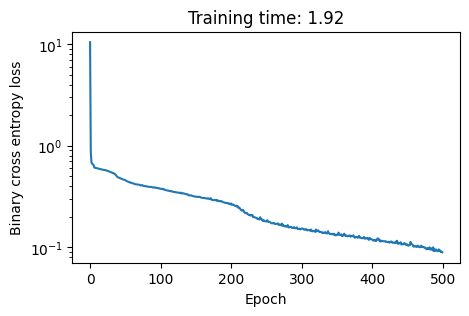

In [13]:
# Set number of epochs
epochs = 500

# Set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Set model to training mode
model.train()

# Model training and validation
epoch_loss = []
start_time = time.time()
for epoch in range(epochs):
    batch_loss = []
    for loader in train_loader:
        loader.to(device)

        optimizer.zero_grad()

        y_pred = model(loader.x, loader.edge_index)

        loss = F.binary_cross_entropy(y_pred, loader.y)

        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    epoch_loss.append(np.mean(batch_loss))

end_time = time.time()
training_time = (end_time - start_time)/60

plt.figure(figsize=(5, 3))
plt.plot(epoch_loss)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Binary cross entropy loss')
plt.title(f'Training time: {training_time:.2f}')
plt.show()
plt.close('all')

#### Save GCN model

In [14]:
torch.save(model, './trained_model/UCGCN_model.pt')

#### GCN model testing

In [15]:
# Load the model
model = torch.load('./trained_model/UCGCN_model.pt')

########################### Testing dataset ###########################
# Get test dataset
test_size = 200
test_dataset = dataset[-test_size:]

# Create test loader
############ Shuffle cannot beb True for testing ##################
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
with torch.no_grad():
    for i, loader in enumerate(test_loader):
        loader.to(device)
        # Get ground true
        ground_true = loader.y.cpu().detach().numpy()
        # Save ground true
        for j in range(batch_size):
            file_path = f'./model_evaluation/GCN/UC_true/true_{i*batch_size+j+1}.csv'
            pd.DataFrame(ground_true[j*unit_length:(j+1)*unit_length]).to_csv(file_path, columns=None, index=None, header=None)

        # Get prediction
        pred = model(loader.x, loader.edge_index)
        pred = (pred>0.5).float()
        pred = pred.cpu().detach().numpy()
        # Save prediction
        for j in range(batch_size):
            file_path = f'./model_evaluation/GCN/UC_pred/pred_{i*batch_size+j+1}.csv'
            pd.DataFrame(pred[j*unit_length:(j+1)*unit_length]).to_csv(file_path, columns=None, index=None, header=None)



########################### Complete dataset ###########################
# Get test dataset
test_dataset = dataset[:]

# Create test loader
############ Shuffle cannot beb True for testing ##################
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
with torch.no_grad():
    for i, loader in enumerate(test_loader):
        loader.to(device)
        # Get ground true
        ground_true = loader.y.cpu().detach().numpy()
        # Save ground true
        for j in range(batch_size):
            file_path = f'./model_evaluation//GCN/UC_true_all/true_{i*batch_size+j+1}.csv'
            pd.DataFrame(ground_true[j*unit_length:(j+1)*unit_length]).to_csv(file_path, columns=None, index=None, header=None)

        # Get prediction
        pred = model(loader.x, loader.edge_index)
        pred = (pred>0.5).float()
        pred = pred.cpu().detach().numpy()
        # Save prediction
        for j in range(batch_size):
            file_path = f'./model_evaluation/GCN/UC_pred_all/pred_{i*batch_size+j+1}.csv'
            pd.DataFrame(pred[j*unit_length:(j+1)*unit_length]).to_csv(file_path, columns=None, index=None, header=None)